## Introduction
I guess **generating additional data by GANs or other generators can be an approach to improve the performance** of CNN classifier. So I've applied one of the best-known GAN "CycleGAN" on the Cassava Leaf dataset.

### What is Cycle GAN?
Cycle GAN is the image style transfer. It translates an image from a source domain to a target domain. Zebra to Horse / Horse to Zebra is well-known examples.

Following images are from original paper.
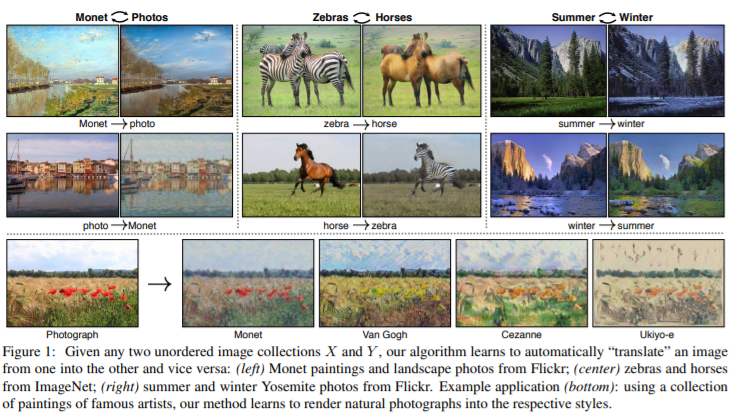

For further information, please check original paper and Monet competition.
* original paper: https://arxiv.org/pdf/1703.10593.pdf
* Monet Competition: https://www.kaggle.com/c/gan-getting-started/overview

### Why Cycle GAN?
In this competition, we need to classify the images of the same plant. The only difference is the health condition.
That inspired me to use Cycle GAN as a health transfer. It might changes the color of leaves, might makes some holes on the leaves.

## Import Libraries

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import math

import pandas as pd
import cv2
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

## Data Pipeline
Data pipeline is defined in this section. 

Noted that the labels are not used as target value in Cycle GAN. Labels are just used for filtering the inputs.

In [ ]:
IMAGE_SIZE = [512, 512]
INPUT_SIZE = [256, 256] #just for fast training
AUTO = tf.data.experimental.AUTOTUNE

def data_pipeline(filenames, label_num, batch_size, is_train=True):
    label_num = tf.constant(label_num, tf.int32)
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    dataset = dataset.filter(lambda x, y: y == label_num)# only seletcted label number can go through
    dataset = dataset.map(lambda x, y: x, num_parallel_calls=AUTO)# do not use label
    if is_train:
        dataset = dataset.map(data_augmentation, num_parallel_calls=AUTO)
        dataset = dataset.shuffle(64)
        dataset = dataset.repeat()
    dataset = dataset.map(resize_and_normalize, num_parallel_calls=AUTO)   
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset

def read_tfrecord(example):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
        }
    example = tf.io.parse_single_example(example, tfrecord_format)
    img = decode_img(example['image'])
    label = tf.cast(example['target'], tf.int32)
    return img, label

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.reshape(img, [*IMAGE_SIZE, 3])
    return img

def data_augmentation(img):
    # horizontal flip
    if tf.random.uniform(()) > 0.5:
        img = img[:, ::-1, :]
    
    # vertical flip
    if tf.random.uniform(()) > 0.5:
        img = img[::-1, :, :]
        
    # random crop
    if tf.random.uniform(()) > 0.3:
        height = tf.random.uniform(shape=(), minval=450, maxval=500)
        width = tf.random.uniform(shape=(), minval=450, maxval=500)
        img = tf.image.random_crop(img, [height,width,3])
    
    # change brightness and contrast
    contrast_rate = tf.random.uniform(shape=(), minval=0.8, maxval=1.2)
    img = tf.image.adjust_contrast(img, contrast_rate)

    brightness_shift = tf.random.uniform(shape=(), minval=-20, maxval=20)
    img = tf.image.adjust_brightness(img, brightness_shift)
    img = tf.clip_by_value(img, 0, 255)

    # change hue
    hue_rate = tf.random.uniform(shape=(), minval=-0.05, maxval=0.05)
    img = tf.image.adjust_hue(img, hue_rate)

    return img
      
def resize_and_normalize(img):
    img = img[tf.newaxis, ...]
    img = tf.image.resize(img, tuple(INPUT_SIZE))[0,:,:,:]
    img = (img/127.5) - 1
    return img

## Define Cycle GAN Model
Models are based on Amy Jang's great notebook. Thank you for sharing!

https://www.kaggle.com/amyjang/monet-cyclegan-tutorial#Visualize-our-Monet-esque-photos

The only difference is the discriminator. I use pretrained model of VGG16 instead of the model given in the original notebook because this classification task is much more difficult than the original task(Monet or photo). 


In [ ]:
def build_gan_models():
    generator_x2y = build_generator()
    generator_y2x = build_generator()
    discriminator_x = build_discriminator()
    discriminator_y = build_discriminator()
    return generator_x2y, generator_y2x, discriminator_x, discriminator_y


def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

def build_generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inputs = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    
    # I use pretrained model of VGG instead of the model given in the original notebook,
    # because this classification task is much more difficult than the original task(Monet or photo). 
    pretrained_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False ,input_shape=[256,256, 3])
    x = pretrained_model(inputs)
    """
    
    down1 = downsample(64, 4, False)(inputs)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)
    """
    last =  tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=last)


def discriminator_loss(real, generated):
    bc_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    real_loss = bc_loss(tf.ones_like(real), real)# real as real
    generated_loss = bc_loss(tf.zeros_like(generated), generated)# fake as fake
    #loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    bc_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)# fake as real
    return bc_loss(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10 * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 5 * loss


class CycleGan(tf.keras.Model):
    def __init__(
        self,
        generator_x2y,
        generator_y2x,
        discriminator_x,
        discriminator_y,
    ):
        super(CycleGan, self).__init__()
        self.generator_x2y = generator_x2y
        self.generator_y2x = generator_y2x
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y
        
    def compile(
        self,
        generator_x2y_optimizer,
        generator_y2x_optimizer,
        discriminator_x_optimizer,
        discriminator_y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.generator_x2y_optimizer = generator_x2y_optimizer
        self.generator_y2x_optimizer = generator_y2x_optimizer
        self.discriminator_x_optimizer = discriminator_x_optimizer
        self.discriminator_y_optimizer = discriminator_y_optimizer
        self.generator_loss = gen_loss_fn
        self.discriminator_loss = disc_loss_fn
        self.cycle_loss = cycle_loss_fn
        self.identity_loss = identity_loss_fn
        
    def train_step(self, batch_data):
        real_x, real_y = batch_data
        with tf.GradientTape(persistent=True) as tape:
            # Generator G translates X -> Y
            # Generator F translates Y -> X.

            fake_y = self.generator_x2y(real_x, training=True)
            cycled_x = self.generator_y2x(fake_y, training=True)

            fake_x = self.generator_y2x(real_y, training=True)
            cycled_y = self.generator_x2y(fake_x, training=True)

            # same_x and same_y are used for identity loss. in half cycle, do not change original image
            same_x = self.generator_y2x(real_x, training=True)
            same_y = self.generator_x2y(real_y, training=True)

            # discriminate 4 images in total
            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_real_y = self.discriminator_y(real_y, training=True)

            disc_fake_x = self.discriminator_x(fake_x, training=True)
            disc_fake_y = self.discriminator_y(fake_y, training=True)

            # calculate the loss
            gen_x2y_loss = self.generator_loss(disc_fake_y)
            gen_y2x_loss = self.generator_loss(disc_fake_x)

            total_cycle_loss = self.cycle_loss(real_x, cycled_x) + self.cycle_loss(real_y, cycled_y)

            # Total generator loss = adversarial loss + cycle loss
            total_gen_x2y_loss = gen_x2y_loss + total_cycle_loss + self.identity_loss(real_y, same_y)
            total_gen_y2x_loss = gen_y2x_loss + total_cycle_loss + self.identity_loss(real_x, same_x)

            disc_x_loss = self.discriminator_loss(disc_real_x, disc_fake_x)
            disc_y_loss = self.discriminator_loss(disc_real_y, disc_fake_y)
      
        # Calculate the gradients for generator and discriminator
        generator_x2y_gradients = tape.gradient(total_gen_x2y_loss, 
                                              self.generator_x2y.trainable_variables)
        generator_y2x_gradients = tape.gradient(total_gen_y2x_loss, 
                                              self.generator_y2x.trainable_variables)
        
        discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                                  self.discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                                  self.discriminator_y.trainable_variables)
      
        # Apply the gradients to the optimizer
        generator_x2y_optimizer.apply_gradients(zip(generator_x2y_gradients, 
                                                  self.generator_x2y.trainable_variables))
    
        generator_y2x_optimizer.apply_gradients(zip(generator_y2x_gradients, 
                                                  self.generator_y2x.trainable_variables))
      
        discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                      self.discriminator_x.trainable_variables))
        
        discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                      discriminator_y.trainable_variables))
    
    
        return {
                "gen_x2y_loss": total_gen_x2y_loss,
                "gen_y2x_loss": total_gen_y2x_loss,
                "disc_x_loss": disc_x_loss,
                "disc_y_loss": disc_y_loss
                }

## Build Data Pipeline
Cycle GAN requires two inputs:
- **Images of Source Domain**
- **Images of Target Domain**

First, I choose "CBSD" as source and "Healthy" as target.  

In [ ]:
batch_size = 1
GCS_PATH = KaggleDatasets().get_gcs_path()
filenames = tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec')
CBSD_data = data_pipeline(filenames, label_num=1, batch_size=batch_size, is_train=True)
Healthy_data = data_pipeline(filenames, label_num=4, batch_size=batch_size, is_train=True)

num_samples = 4
fig, axes = plt.subplots(2,num_samples, figsize=(12,6))
for i, data in enumerate(CBSD_data.take(num_samples)):
    axes[0, i].imshow(data[0].numpy() * 0.5 + 0.5)
    axes[0, i].title.set_text("CBSD")
    
for i, data in enumerate(Healthy_data.take(num_samples)):
    axes[1, i].imshow(data[0].numpy() * 0.5 + 0.5)
    axes[1, i].title.set_text("Healthy")    

fig.tight_layout()
plt.show()


## Train Models
Let's start training! 

As I don't want to break the pretrained weights of disciminators(VGG16) at initial epochs, weights are frozen at first 3 epochs. Then train all layers.

In [ ]:
data_num = 2000
learning_rate = 1e-4
batch_size = 1

with strategy.scope(): 
    generator_x2y, generator_y2x, discriminator_x, discriminator_y = build_gan_models()


    # loss and learning rate
    generator_x2y_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    generator_y2x_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    discriminator_x_optimizer = tf.keras.optimizers.Adam(learning_rate/10, beta_1=0.5)
    discriminator_y_optimizer = tf.keras.optimizers.Adam(learning_rate/10, beta_1=0.5)

    cycle_gan_model = CycleGan(generator_x2y, generator_y2x, discriminator_x, discriminator_y)


    def compile_and_fit(epochs):
        cycle_gan_model.compile(generator_x2y_optimizer, generator_y2x_optimizer,
                                discriminator_x, discriminator_y,
                                generator_loss,
                                discriminator_loss,
                                calc_cycle_loss,
                                identity_loss
                                )
        cycle_gan_model.fit(tf.data.Dataset.zip((CBSD_data, Healthy_data)),
                            batch_size = batch_size,
                            steps_per_epoch = data_num//batch_size, 
                            epochs=epochs
                           )    


    # I don't want to break the pretrained weight of disciminator at initial epochs.
    discriminator_x.trainable = False
    discriminator_y.trainable = False
    compile_and_fit(epochs=3)

    discriminator_x.trainable = True
    discriminator_y.trainable = True
    compile_and_fit(epochs=10)

    cycle_gan_model.save_weights("gan_10ep_CBSD_healthy.h5")

## Check Generated Image

### CBSD to HEALTHY

In [ ]:
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0]]
    title = ['Original Image', 'Generated Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

for inputs in CBSD_data.take(12):
    generate_images(generator_x2y, inputs)

Some images look healthy comparing with the original images.

### HEALTHY to CBSD

In [ ]:
for inputs in Healthy_data.take(12):
    generate_images(generator_y2x, inputs) 

Colors and patterns of leaves look slightly changing. They are somewhat unhealthy.

## Other Transforms

### 1. CBB <-> HEALTHY

In [ ]:
CBB_data = data_pipeline(filenames, label_num=0, batch_size=batch_size, is_train=True)
with strategy.scope(): 
    generator_x2y, generator_y2x, discriminator_x, discriminator_y = build_gan_models()

    generator_x2y_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    generator_y2x_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_x_optimizer = tf.keras.optimizers.Adam(learning_rate/10, beta_1=0.5)
    discriminator_y_optimizer = tf.keras.optimizers.Adam(learning_rate/10, beta_1=0.5)
    
    cycle_gan_model = CycleGan(generator_x2y, generator_y2x, discriminator_x, discriminator_y)

    def compile_and_fit(epochs):
        cycle_gan_model.compile(generator_x2y_optimizer, generator_y2x_optimizer,
                                discriminator_x, discriminator_y,
                                generator_loss,
                                discriminator_loss,
                                calc_cycle_loss,
                                identity_loss
                                )
        cycle_gan_model.fit(tf.data.Dataset.zip((CBB_data, Healthy_data)),
                            batch_size = batch_size,
                            steps_per_epoch = data_num//batch_size, 
                            epochs=epochs
                           )    


    # I don't want to break the pretrained weight of disciminator at initial epochs.
    discriminator_x.trainable = False
    discriminator_y.trainable = False
    compile_and_fit(epochs=3)

    discriminator_x.trainable = True
    discriminator_y.trainable = True
    compile_and_fit(epochs=10)

    cycle_gan_model.save_weights("gan_10ep_CBB_healthy.h5")


#### CBB to HEALTHY

In [ ]:
for inputs in CBB_data.take(12):
    generate_images(generator_x2y, inputs)

#### HEALTHY to CBB

In [ ]:
for inputs in Healthy_data.take(12):
    generate_images(generator_y2x, inputs)

Training multiple CycleGANs takes a lot of time. So I'm plannning to implement StarGANv2 to create images across multiple domain (multiple classes).

## Next Step
Generated images shown above are not so good at this point. So the next step is tuning models and hyper parameters to generate better images. Then train classifier with newly generated images (fake images) and compare its performance with the original classifier.

Thank you for reading!